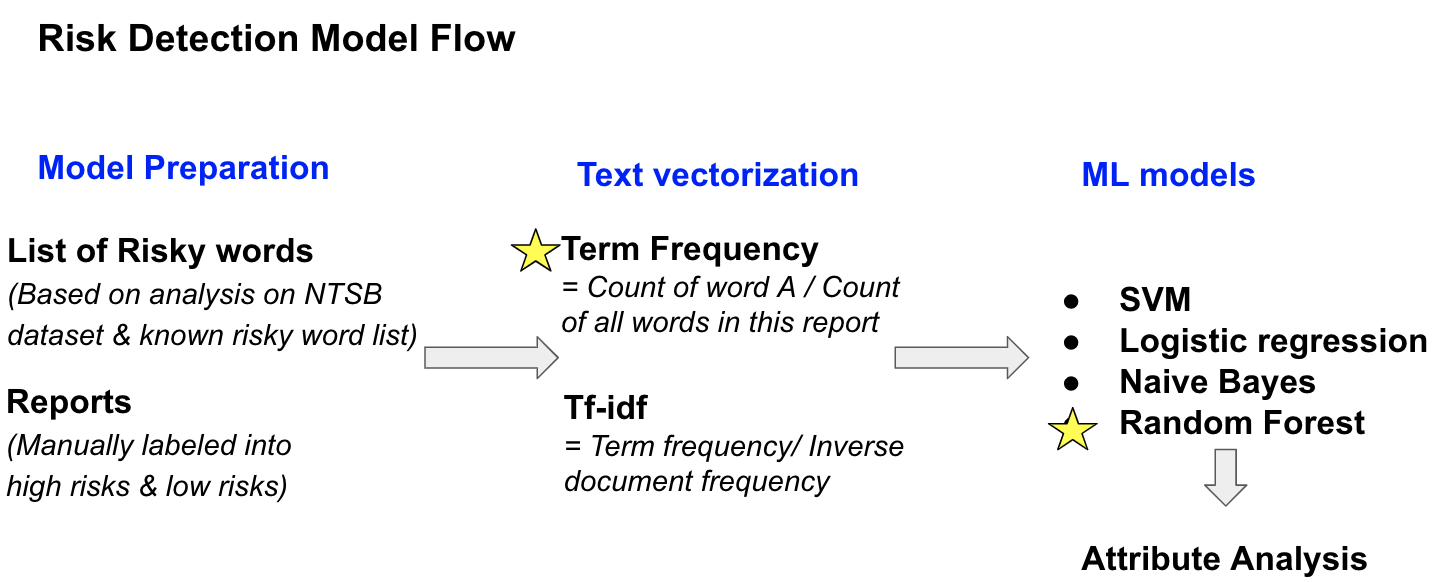

# Definition of riskiness detection classification
### High-risk reports: 
1. Huge terbulence; Obvious out of control
2. some people get hurt; 
3. the main parts of aircraft are damaged; 

### Low-risk reports: 
1. Mismanipulation; 
2. Small parts of the aircrafts are damaged; 
3. Nobody gets hurt

In [24]:
import string
from nltk.corpus import stopwords
import nltk 
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
import numpy as np
import re
from collections import Counter
import csv
from nltk import stem
# import difflib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime

#Tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/crystal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/crystal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

In [26]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Preparation for Abbreviation Dictionary

In [27]:
abbreviation = pd.read_csv("abbreviation_dictionary.csv")

In [28]:
abbreviation.head()

,Name,Form
0,Above Ground Level,AGL
1,Actual Time Of Arrival/Air Traffic Area,ATA
2,Actual Time Of Departure,ATD
3,Aeronautical,AERO
4,Aeronautical Information Manual,AIM


In [29]:
#Create the dictionary
dict_abb = {}
for i in range(len(abbreviation)):   
    word = ' '+abbreviation.iloc[i,1]+' '
    value = ' '+abbreviation.iloc[i,0]+' '
    dict_abb[word] = value
dict_abb = {k.lower(): v.lower() for k, v in dict_abb.items()}

# ASRS dataset

In [30]:
asrs = pd.read_excel('asrs_stratified_sample.xlsx')
# drop rows without labels
asrs.dropna(subset =['riskiness'],inplace = True)
asrs = asrs.reset_index()
asrs.drop(['index','Unnamed: 0'],axis =1,inplace = True)
asrs.head(2)

,acn,year,month,local_time,airport,airport_code,airport_type,airport_name,airport_lat,airport_long,...,atc_steps,assessments,assessments.1,riskiness,report 1,report 1.1,report 2,report 2.1,report 1.2,narra_length
0,1372570,2015,7,1201-1800,JVW.Airport,JVW,Airport,John Bell Williams,32.303341,-90.408493,...,Flight Crew Took Evasive Action,Human Factors,Human Factors,0.0,The winds were variable; favoring either runwa...,NaN,NaN,NaN,C172 instructor pilot reported braking abruptl...,0
1,967887,2011,9,0601-1200,ZZZ.Airport,ZZZ,Airport,NaN,NaN,NaN,...,Aircraft Aircraft Damaged; General Maintenance...,Aircraft,Aircraft,1.0,Upon touchdown; we heard a loud pop followed b...,NaN,NaN,NaN,When a tire blew out on landing; the flight cr...,0


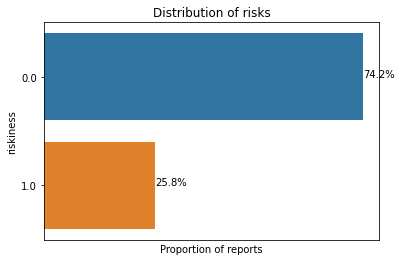

In [31]:
# The proportion of high and low risk reports
fig = plt.figure(figsize = (6,4))
ax = sns.countplot(y="riskiness", data=asrs)
plt.title('Distribution of risks')
plt.xlabel('Proportion of reports')
plt.xticks([])

total = len(asrs['riskiness'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.show()

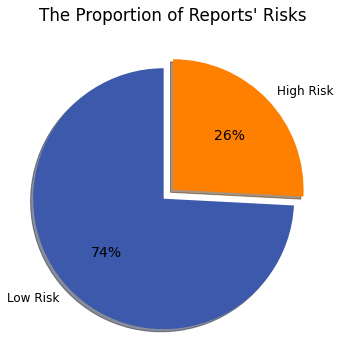

In [121]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 14.0
# draw a pie chart to show the ratio of 'Negative', 'Neutral' and 'Positive' tweets
fig = plt.figure(figsize=(6,6))
labels = 'Low Risk', 'High Risk',
sizes = asrs.groupby('riskiness').acn.count().values
colors = [ '#3D59AB', '#FF8000']

#191970
explode = (0.1, 0) 

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%2.0f%%', shadow=True, startangle=90,)
plt.title("The Proportion of Reports' Risks",)
plt.show()

## text preprocessing

In [33]:
#decontraction
def decontracted(phrase):
    # specific
    phrase = re.sub(r"that\'s", "that is", phrase)       
    phrase = re.sub(r"go-around", "go around", phrase)  
    # general
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

asrs['report_1_new'] = asrs['report 1'].apply(lambda x: decontracted(x.lower()))

In [34]:
# remoce punctuations
def remove_punc(mess):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ' '+''.join(nopunc)+' '
    return nopunc

string.punctuation = string.punctuation.replace("-", "").replace("'", "")

asrs['report_1_new'] = asrs['report_1_new'].apply(lambda x: remove_punc(x))

In [35]:
# replace abbreviations with words
def replace_abbreviation(string):
    for k, v in dict_abb.items():
        string = string.replace(k, v)
    return string

asrs['report_1_new'] = asrs['report_1_new'].apply(lambda x: replace_abbreviation(x))

In [36]:
# remove stopwords
stop_words = stopwords.words('english')
common_words =['the','would','could']
stop_words.extend(word for word in common_words if word not in stop_words)

asrs['report_1_new'] = asrs['report_1_new'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words and word != '']))

In [37]:
# lemmantize
lemmatizer = WordNetLemmatizer() 
asrs['report_1_new'] = asrs['report_1_new'].apply(lambda x:  ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [38]:
# concat words
def concat_word(phrase):
    # specific
    phrase = re.sub(r"decision making", "decision-making", phrase)
    phrase = re.sub(r"human factors", "human-factors", phrase)
    phrase = re.sub(r"instrument meteorological conditions", "instrument-meteorological-conditions", phrase)
    phrase = re.sub(r"lost control", "lost-control", phrase)
    phrase = re.sub(r"near miss", "near-miss", phrase)
    phrase = re.sub(r"situational awareness", "situational-awareness", phrase)
    phrase = re.sub(r"anti icing", "anti-icing", phrase)       
    phrase = re.sub(r"off runway", "off-runway", phrase)  
    return phrase

asrs['report_1_new'] = asrs['report_1_new'].apply(lambda x: concat_word(x))

## Creating dictionary of risky words

In [122]:
risky_words = ["Accident","Airspeed","Attitude","broke","broken",
"clipped","collapse","Collision","Communication","Currency",
"damage","Death","Deicing","dent","disoriented","Diverting",
"Emergency","Engine","Error","Failed","failure","Fatal","Fear","fire",
"Hail","Hypoxia","Ice","Icing","impact","Incident","Incursion","Injured","Injury","Life",
"Lightning","Midair","Mistake","Overshoot","Overshot","Oxygen","Proficiency","Regulation","Risk",
"scared","skid","slid","slide","snapped","Spin","Stall","strike","struck","suddenly",
"terminated","Thunderstorm","Turbulence","Undershoot","Weather",
"Decision-making","Human-factors","instrument-meteorological-conditions","lost-control",
"Near-miss","Situational-awareness","Wind-shear","Anti-icing","off-airport","off-runway"]

new_risky_words = ["collapsed","collided","colliding","miscommunication","damaged","deice","deiced",
                   "diverted","divert","fearing","feared","fail","failing"]

new_risky_words_NTSB = ['nosed','fuel','forced','nose','loss','lost','student','tree','malfunction',
                        'power', 'valve','helicopter','altitude','wind', 'certified','mechanical','roll','stop',
                        'landing','passenger','gear','propeller','touchdown','examination', 'land','wing']

In [124]:
len(risky_words)+len(new_risky_words)

81

In [40]:
risky_words = risky_words + new_risky_words + new_risky_words_NTSB
risky_words =[char.lower() for char in risky_words]

In [119]:
len(risky_words)

107

## Text vectorization 1: bag-of-words

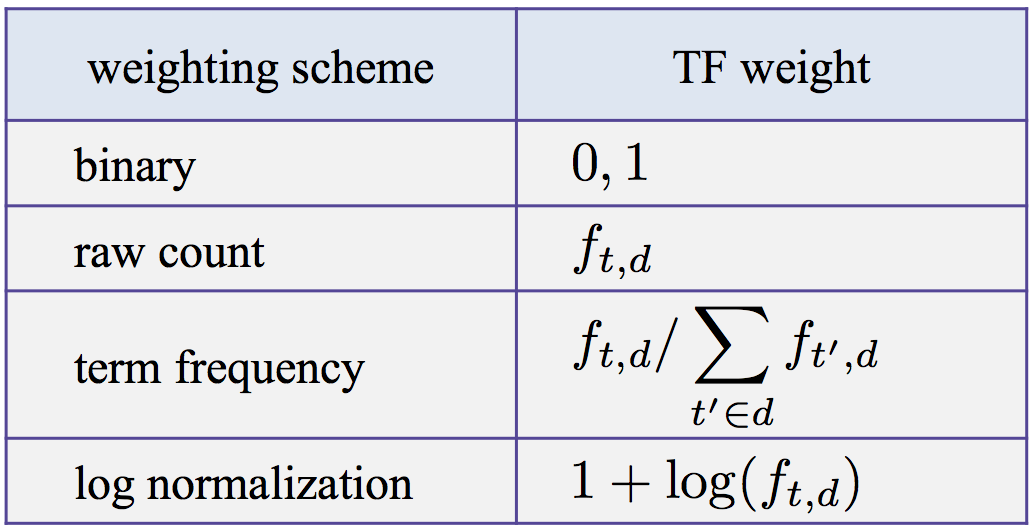

In [41]:
def term_frequency(documents,words):
    sentence_vectors = []
    for sentence in documents:
        sentence_tokens = nltk.word_tokenize(sentence)
        sent_vec = []
        for token in words:
            if token in sentence_tokens:
                sent_vec.append(len(token))
            else:
                sent_vec.append(0)

        term_frequency = [term/len(str(sentence).split(" ")) for term in sent_vec]
        sentence_vectors.append(term_frequency)

    term_frequency = pd.DataFrame(sentence_vectors)
    term_frequency.columns= words
    return term_frequency

term_frequency_start = term_frequency(asrs['report_1_new'],risky_words)

In [42]:
print(term_frequency_start.shape)
term_frequency_start.tail()

(302, 107)


,accident,airspeed,attitude,broke,broken,clipped,collapse,collision,communication,currency,...,roll,stop,landing,passenger,gear,propeller,touchdown,examination,land,wing
297,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.015021,0.0,0.0,0.019313,0.0,0.0,0.008584,0.000000
298,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.030516,0.0,...,0.000000,0.000000,0.016432,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
299,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.000000,0.0,...,0.010526,0.000000,0.018421,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
300,0.0,0.0,0.0,0.010917,0.0131,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
301,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.008639,0.015119,0.0,0.0,0.019438,0.0,0.0,0.000000,0.008639


## Text vectorization 2: Tf-idf

In [43]:
def binary_BOW(documents,words):
    sentence_vectors = []
    for sentence in documents:
        sentence_tokens = nltk.word_tokenize(sentence)
        sent_vec = []
        for token in words:
            if token in sentence_tokens:
                sent_vec.append(1)
            else:
                sent_vec.append(0)
        sentence_vectors.append(sent_vec)

    bag_of_words = pd.DataFrame(sentence_vectors)
    bag_of_words.columns= words
#    bag_of_words['risk_count']=bag_of_words.sum(axis =1)

    return(list(bag_of_words.transpose().apply(lambda x: dict(x))))
    
bag_of_words_start = binary_BOW(asrs['report_1_new'],risky_words)

In [44]:
# data frequency
def computeDF(documents):    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = float(val)
    return idfDict

dfs = computeDF(bag_of_words_start)

In [45]:
#delet risky words if they never show up in any reports
frequent_risky_words = dict()
for (key, value) in dfs.items():
    if value > 0:
        frequent_risky_words[key] = value
frequent_risky_words = frequent_risky_words.keys()

In [46]:
term_frequency_final = term_frequency(asrs['report_1_new'],frequent_risky_words)
bag_of_words_final = binary_BOW(asrs['report_1_new'],frequent_risky_words)

In [47]:
#inverse data frequency
def computeIDF(documents):
    import math
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

idfs = computeIDF(bag_of_words_final)

In [48]:
def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

tfidf = pd.DataFrame([computeTFIDF(term_frequency_final.iloc[i,:],idfs) for i in range(len(term_frequency_final))])

In [49]:
print(tfidf.shape)
tfidf.tail()

(302, 96)


,accident,airspeed,attitude,broke,broken,clipped,collapse,collision,communication,currency,...,roll,stop,landing,passenger,gear,propeller,touchdown,examination,land,wing
297,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.008899,0.0,0.0,0.042182,0.0,0.0,0.010203,0.000000
298,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.056769,0.0,...,0.000000,0.000000,0.009735,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
299,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.025417,0.000000,0.010913,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
300,0.0,0.0,0.0,0.030787,0.036944,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
301,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.015198,0.008957,0.0,0.0,0.042455,0.0,0.0,0.000000,0.018138


## Resampling & Seperate train and test dataset

In [50]:
BOW_model = pd.concat([asrs['riskiness'],term_frequency_final], axis = 1)
tfidf_model = pd.concat([asrs['riskiness'],tfidf], axis = 1)

In [51]:
#proportion before resampling
asrs['riskiness'].value_counts()

0.0    224
1.0     78
Name: riskiness, dtype: int64

In [52]:
#resample minority group to make the dataset more balanced
#after resampling, the majority is 5 times of minority
def re_sample(dataframe):
    minority = dataframe[dataframe['riskiness'] == 1]
    majority = dataframe[dataframe['riskiness'] == 0]
    minority_resampled = resample(minority, replace = True, n_samples = int(len(majority)), random_state = 123)
    new_dataframe = pd.concat([majority, minority_resampled])
    return(new_dataframe)

In [53]:
BOW_model = re_sample(BOW_model)
tfidf_model = re_sample(tfidf_model)
tfidf_model.riskiness.value_counts()

1.0    224
0.0    224
Name: riskiness, dtype: int64

In [54]:
y_BOW = BOW_model['riskiness']
X_BOW = BOW_model.drop(['riskiness'],axis = 1)
X_BOW_train, X_BOW_test, y_BOW_train, y_BOW_test = train_test_split(X_BOW,y_BOW, test_size=0.2, random_state=101)

y_tfidf = tfidf_model['riskiness']
X_tfidf = tfidf_model.drop(['riskiness'],axis = 1)
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, y_tfidf, test_size=0.3, random_state=101)

# Riskiness Prediction

High precision means that an algorithm returned substantially more relevant results than irrelevant ones, while high recall means that an algorithm returned most of the relevant results.

# Random Forest

In [61]:
def Random_Forest(X_train, X_test, y_train, y_test):
    #fitting the model
    rf = RandomForestClassifier(n_estimators= 100, oob_score=True, random_state=10)
    rf.fit(X_train, y_train)
    Y_pred = rf.predict(X_test)
    print(classification_report(y_test,Y_pred))

In [62]:
print('Classification report for Random_Forest with Term Frequency')
Random_Forest(X_BOW_train, X_BOW_test, y_BOW_train, y_BOW_test)

Classification report for Random_Forest with Term Frequency
              precision    recall  f1-score   support

         0.0       0.95      0.83      0.88        46
         1.0       0.84      0.95      0.89        44

    accuracy                           0.89        90
   macro avg       0.90      0.89      0.89        90
weighted avg       0.90      0.89      0.89        90



In [63]:
print('Classification report for Random_Forest with Tf-idf')
Random_Forest(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test)

Classification report for Random_Forest with Tf-idf
              precision    recall  f1-score   support

         0.0       0.95      0.75      0.84        73
         1.0       0.77      0.95      0.85        62

    accuracy                           0.84       135
   macro avg       0.86      0.85      0.84       135
weighted avg       0.86      0.84      0.84       135



Text(0.5, 1.0, 'The importances of features')

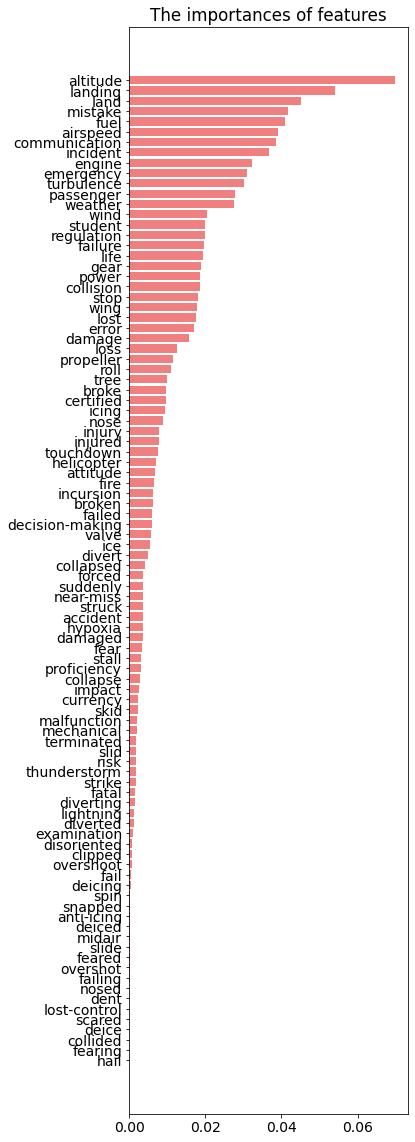

In [64]:
rf = RandomForestClassifier(n_estimators= 100, oob_score=True, random_state=10)
rf.fit(X_BOW_train, y_BOW_train)

feature_importances = pd.DataFrame(rf.feature_importances_,
                      index = X_BOW_train.columns,
                     columns=['importance']).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(5,20))
barlist =plt.barh(range(len(feature_importances['importance'])), feature_importances['importance'],color = 'lightcoral')
ax.set_yticks(range(len(feature_importances['importance'])))
ax.set_yticklabels(feature_importances.index)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.title('The importances of features')

## Use significant features to do random forest classification

In [65]:
sig_risky_words = feature_importances[feature_importances.importance>0.01].index

In [66]:
sig_risky_words

Index(['tree', 'roll', 'propeller', 'loss', 'damage', 'error', 'lost', 'wing',
       'stop', 'collision', 'power', 'gear', 'life', 'failure', 'regulation',
       'student', 'wind', 'weather', 'passenger', 'turbulence', 'emergency',
       'engine', 'incident', 'communication', 'airspeed', 'fuel', 'mistake',
       'land', 'landing', 'altitude'],
      dtype='object')

In [120]:
len(sig_risky_words)

30

In [67]:
sig_term_frequency = term_frequency(asrs['report_1_new'], sig_risky_words)
updated_BOW_model = pd.concat([asrs['riskiness'],sig_term_frequency], axis = 1)
updated_BOW_model = re_sample(updated_BOW_model)
y_BOW = updated_BOW_model['riskiness']
X_BOW = updated_BOW_model.drop(['riskiness'],axis = 1)
X_BOW_train, X_BOW_test, y_BOW_train, y_BOW_test = train_test_split(X_BOW,y_BOW, test_size=0.2, random_state=101)

In [68]:
Random_Forest(X_BOW_train, X_BOW_test, y_BOW_train, y_BOW_test)

              precision    recall  f1-score   support

         0.0       0.95      0.83      0.88        46
         1.0       0.84      0.95      0.89        44

    accuracy                           0.89        90
   macro avg       0.90      0.89      0.89        90
weighted avg       0.90      0.89      0.89        90



Text(0.5, 1.0, 'The importances of significant features')

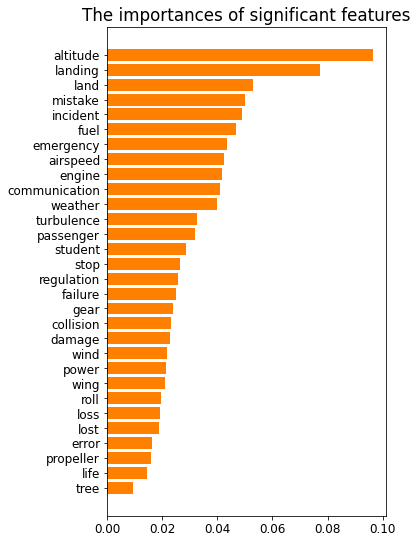

In [74]:
rf = RandomForestClassifier(n_estimators= 100, oob_score=True, random_state=10)
rf.fit(X_BOW, y_BOW)

feature_importances = pd.DataFrame(rf.feature_importances_,
                      index = X_BOW_train.columns,
                     columns=['importance']).sort_values('importance', ascending=True)

rf = RandomForestClassifier(n_estimators= 100, oob_score=True, random_state=10)
fig, ax = plt.subplots(figsize=(5,9))

barlist =plt.barh(range(len(feature_importances['importance'])), feature_importances['importance'],color = '#FF8000')
ax.set_yticks(range(len(feature_importances['importance'])))
ax.set_yticklabels(feature_importances.index)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.title('The importances of significant features')

Text(0.5, 1.0, 'The importances of significant features')

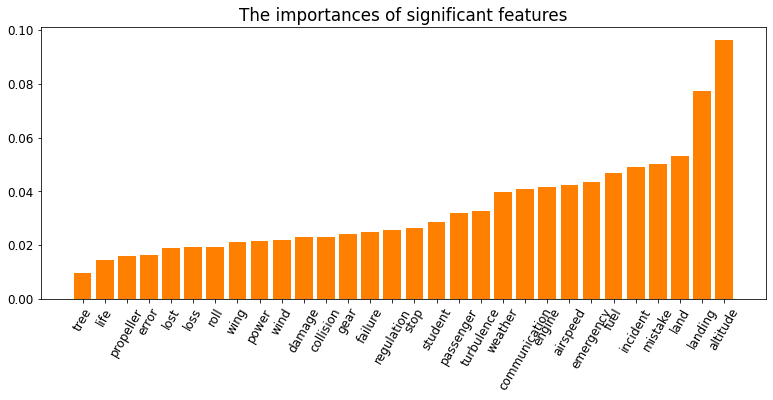

In [118]:
fig, ax = plt.subplots(figsize=(13,5))
barlist =plt.bar(feature_importances.index,feature_importances['importance'], color = '#FF8000')
ax.set_xticks(range(len(feature_importances['importance'])))
ax.set_xticklabels(feature_importances.index)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.xticks(rotation=60)
plt.title('The importances of significant features')

- Resources:
- https://www.kaggle.com/learn/machine-learning-explainability
- https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e